In [1]:
import geopandas as gpd

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(r"C:\Users\vibhu\Downloads\LS_mask\UKCP_18_09\Bias Corrected Imputation\TAS_1980-2010\Imputing Points\Points\UK_PPT_DEM_12km_impute.shp")

# Filter the GeoDataFrame to include only coastal points
coastal_points = gdf[gdf['classifica'] == 'coastal']

# Extract the required columns
coastal_data = coastal_points[['latitude', 'longitude', 'value']]

# Save the extracted data to a CSV file
coastal_data.to_csv('coastal_points.csv', index=False)


In [12]:
import pandas as pd
import numpy as np
from scipy import stats
# Load the CSV file
file_path =  "gwr_bias_corr_bootstrap.csv"
df = pd.read_csv(file_path)

# Function to calculate the 95% confidence interval
def confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    se = np.std(data, ddof=1) / np.sqrt(n)
    # Calculate the critical value for the given confidence level
    critical_value = stats.norm.ppf((1 + confidence) / 2)
    h = se * critical_value # For a 95% confidence interval
    return m - h, m + h

# Initialize lists to store results
latitudes = []
longitudes = []
means = []
medians = []
lower_bounds = []
upper_bounds = []

# Iterate over each row to calculate the statistics
for index, row in df.iterrows():
    # Convert the string of values into a list of floats
    imputed_values = list(map(float, row['imputed_values'].split(',')))
    
    # Calculate mean, median, and confidence interval
    mean_val = np.mean(imputed_values)
    median_val = np.median(imputed_values)
    lower_bound, upper_bound = confidence_interval(imputed_values)
    
    # Append results to lists
    latitudes.append(row['latitude'])
    longitudes.append(row['longitude'])
    means.append(mean_val)
    medians.append(median_val)
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)

# Create a new DataFrame with the calculated statistics
results_df = pd.DataFrame({
    'latitude': latitudes,
    'longitude': longitudes,
    'mean': means,
    'median': medians,
    'ci_lower': lower_bounds,
    'ci_upper': upper_bounds
})

# Save the results to a new CSV file
output_file_path = r"gwr_bias_corr_bootstrap_stats.csv"
results_df.to_csv(output_file_path, index=False)


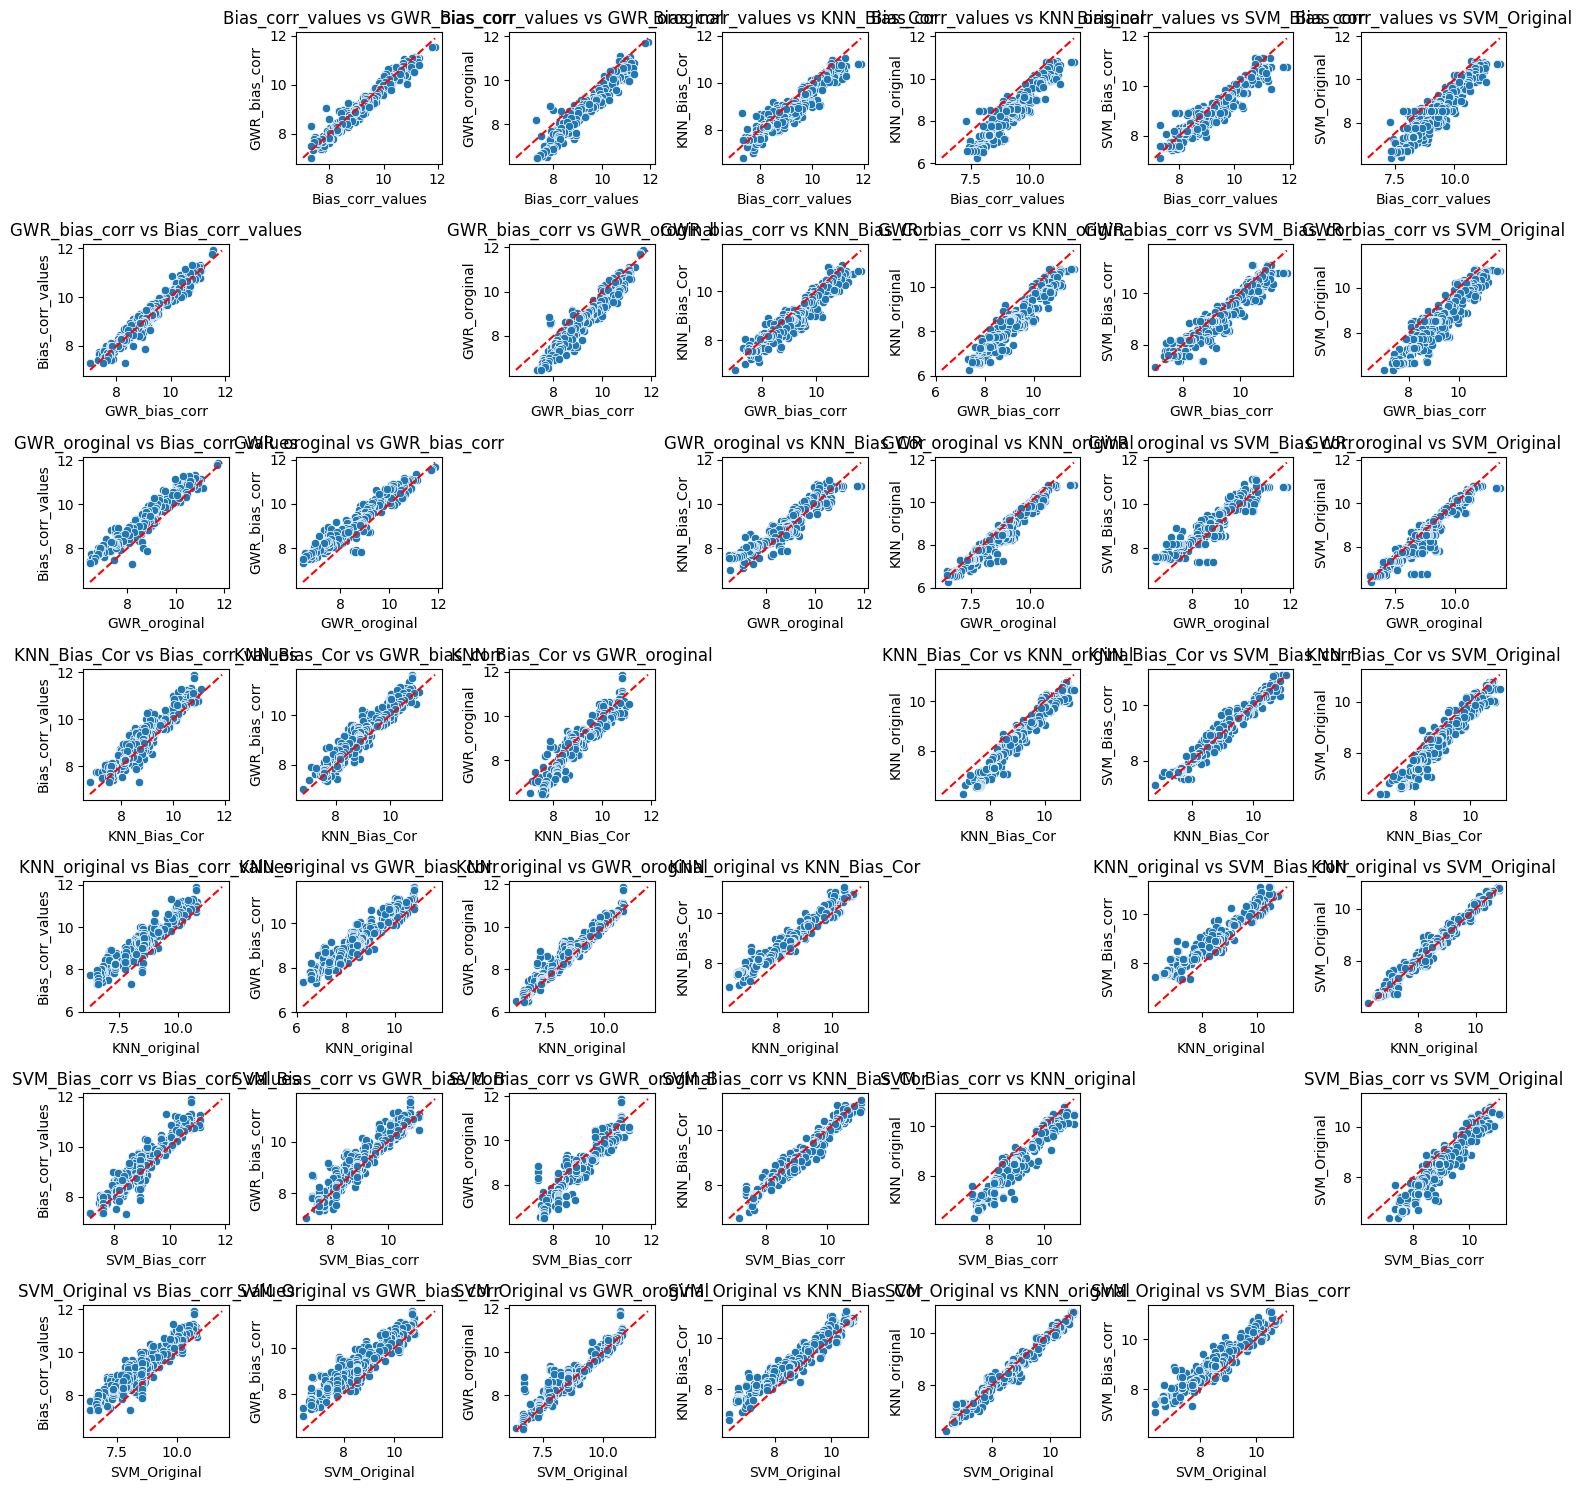

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Define file paths and corresponding method names
# Define file paths and corresponding method names
file_paths = [
    ('SVM_bootstrap_imputed_original_stats.csv', 'SVM_Original'),
    ('SVM_bootstrap_Bias_corr_stats.csv', 'SVM_Bias_corr'),
    ('KNN_bootstrap_Bias_cor_stats.csv', 'KNN_Bias_Cor'),
    ('KNN_bootstrap_original_stats.csv', 'KNN_original'),
    ('coastal_points2.csv', 'Bias_corr_values') ,
    ('gwr_original_bootstrap_stats.csv', 'GWR_oroginal'), 
    ("gwr_bias_corr_bootstrap_stats.csv","GWR_bias_corr")
      # Add new file and method name here
]

# Initialize a list to store DataFrames
dfs = []

# Load each file, add method label, and keep only relevant columns
for file_path, method_name in file_paths:
    df = pd.read_csv(file_path)
    df['method'] = method_name  # Add method label to each DataFrame
    dfs.append(df[['latitude', 'longitude', 'mean', 'method']])  # Keep only relevant columns

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Pivot the DataFrame to have a column for each method's mean values
pivot_df = combined_df.pivot_table(index=['latitude', 'longitude'], columns='method', values='mean').reset_index()

# List of methods to compare
methods = [col for col in pivot_df.columns if col not in ['latitude', 'longitude']]

# Create a scatter plot for each pair of methods
num_methods = len(methods)
fig, axes = plt.subplots(nrows=num_methods, ncols=num_methods, figsize=(15, 15))

for i, j in itertools.product(range(num_methods), repeat=2):
    if i != j:
        ax = axes[i, j]
        # Extract data for the two methods being compared
        method1 = methods[i]
        method2 = methods[j]
        
        x_data = pivot_df[method1].dropna()
        y_data = pivot_df[method2].dropna()
        
        # Ensure equal lengths for scatter plot by aligning indices
        common_indices = x_data.index.intersection(y_data.index)
        x_data = x_data.loc[common_indices]
        y_data = y_data.loc[common_indices]
        
        # Plot scatter plot
        sns.scatterplot(x=x_data, y=y_data, ax=ax)
        
        # Add y=x reference line
        min_val = min(x_data.min(), y_data.min())
        max_val = max(x_data.max(), y_data.max())
        ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
        
        ax.set_xlabel(method1)
        ax.set_ylabel(method2)
        ax.set_title(f'{method1} vs {method2}')
    else:
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


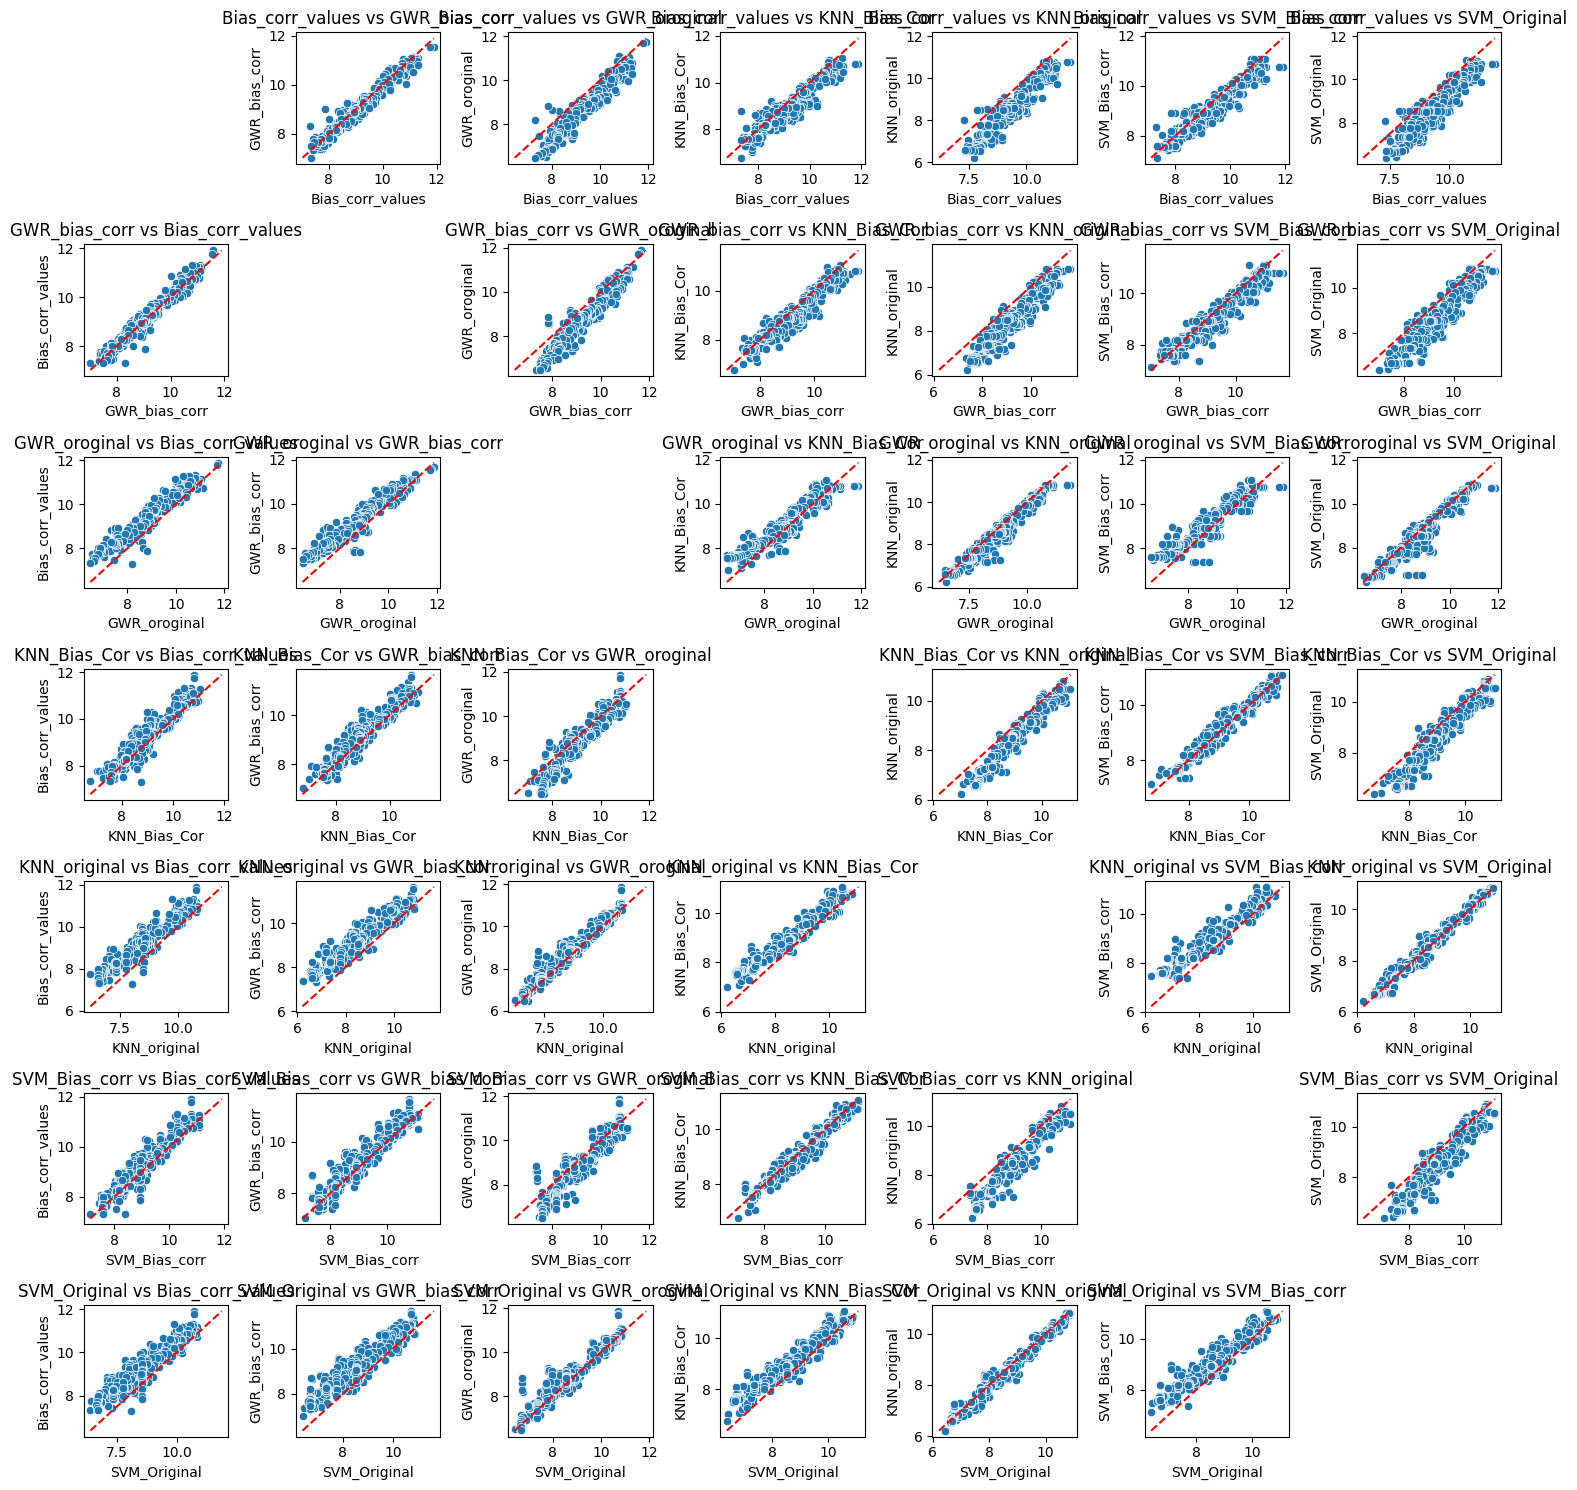

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Define file paths and corresponding method names
file_paths = [
    ('SVM_bootstrap_imputed_original_stats.csv', 'SVM_Original'),
    ('SVM_bootstrap_Bias_corr_stats.csv', 'SVM_Bias_corr'),
    ('KNN_bootstrap_Bias_cor_stats.csv', 'KNN_Bias_Cor'),
    ('KNN_bootstrap_original_stats.csv', 'KNN_original'),
    ('coastal_points2.csv', 'Bias_corr_values'),
    ('gwr_original_bootstrap_stats.csv', 'GWR_oroginal') , 
    ("gwr_bias_corr_bootstrap_stats.csv","GWR_bias_corr")    # Add new file and method name here
]

# Initialize a list to store DataFrames
dfs = []

# Load each file, add method label, and keep only relevant columns
for file_path, method_name in file_paths:
    df = pd.read_csv(file_path)
    df['method'] = method_name  # Add method label to each DataFrame
    dfs.append(df[['latitude', 'longitude', 'median', 'method']])  # Keep only relevant columns

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Pivot the DataFrame to have a column for each method's mean values
pivot_df = combined_df.pivot_table(index=['latitude', 'longitude'], columns='method', values='median').reset_index()

# List of methods to compare
methods = [col for col in pivot_df.columns if col not in ['latitude', 'longitude']]

# Create a scatter plot for each pair of methods
num_methods = len(methods)
fig, axes = plt.subplots(nrows=num_methods, ncols=num_methods, figsize=(15, 15))

for i, j in itertools.product(range(num_methods), repeat=2):
    if i != j:
        ax = axes[i, j]
        # Extract data for the two methods being compared
        method1 = methods[i]
        method2 = methods[j]
        
        x_data = pivot_df[method1].dropna()
        y_data = pivot_df[method2].dropna()
        
        # Ensure equal lengths for scatter plot by aligning indices
        common_indices = x_data.index.intersection(y_data.index)
        x_data = x_data.loc[common_indices]
        y_data = y_data.loc[common_indices]
        
        # Plot scatter plot
        sns.scatterplot(x=x_data, y=y_data, ax=ax)
        
        # Add y=x reference line
        min_val = min(x_data.min(), y_data.min())
        max_val = max(x_data.max(), y_data.max())
        ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
        
        ax.set_xlabel(method1)
        ax.set_ylabel(method2)
        ax.set_title(f'{method1} vs {method2}')
    else:
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [15]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load the reference file
reference_file = 'coastal_points.csv'   # Update with your reference file path
reference_df = pd.read_csv(reference_file)

# Define file paths for imputed values
imputed_files = [
    'SVM_bootstrap_imputed_original_stats.csv',
    'SVM_bootstrap_Bias_corr_stats.csv',
    'KNN_bootstrap_Bias_cor_stats.csv',
    'KNN_bootstrap_original_stats.csv',
    'gwr_original_bootstrap_stats.csv',
    "gwr_bias_corr_bootstrap_stats.csv"
]

# Initialize a list to store results for each point
results = []

# Iterate over each imputed file
for file_path in imputed_files:
    imputed_df = pd.read_csv(file_path)
    
    # Merge the imputed data with the reference data based on latitude and longitude
    merged_df = pd.merge(reference_df, imputed_df[['latitude', 'longitude', 'mean', 'median']], on=['latitude', 'longitude'], how='left')
    
    # Drop rows where any of the values are NaN (no matching point found)
    merged_df = merged_df.dropna(subset=['mean', 'median', 'value'])
    
    # Calculate MSE for each point
    merged_df['mse_mean'] = (merged_df['value'] - merged_df['mean']) ** 2
    merged_df['mse_median'] = (merged_df['value'] - merged_df['median']) ** 2
    
    # Add method name to the DataFrame
    merged_df['method'] = file_path
    
    # Append results to the list
    results.append(merged_df[['latitude', 'longitude', 'value', 'mean', 'median', 'mse_mean', 'mse_median', 'method']])

# Combine results into a single DataFrame
mse_results_df = pd.concat(results, ignore_index=True)

# Save the results to a new CSV file
mse_results_df.to_csv('mse_results_per_point.csv', index=False)

# Print the overall MSE for each file
overall_mse_mean = mse_results_df.groupby('method')['mse_mean'].mean()
overall_mse_median = mse_results_df.groupby('method')['mse_median'].mean()

print("Overall MSE for Mean:")
print(overall_mse_mean)

print("\nOverall MSE for Median:")
print(overall_mse_median)


Overall MSE for Mean:
method
KNN_bootstrap_Bias_cor_stats.csv            0.179356
KNN_bootstrap_original_stats.csv            0.781266
SVM_bootstrap_Bias_corr_stats.csv           0.157795
SVM_bootstrap_imputed_original_stats.csv    0.632004
gwr_bias_corr_bootstrap_stats.csv           0.050120
gwr_original_bootstrap_stats.csv            0.462505
Name: mse_mean, dtype: float64

Overall MSE for Median:
method
KNN_bootstrap_Bias_cor_stats.csv            0.170800
KNN_bootstrap_original_stats.csv            0.771008
SVM_bootstrap_Bias_corr_stats.csv           0.144494
SVM_bootstrap_imputed_original_stats.csv    0.609769
gwr_bias_corr_bootstrap_stats.csv           0.049637
gwr_original_bootstrap_stats.csv            0.463316
Name: mse_median, dtype: float64
